In [1]:
import numpy as np
from astropy.table import Table
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import pandas as pd
from itertools import combinations
import networkx as nx
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import itertools

In [2]:
def open_webtype(webtype,randiter,zone):
        group = Table.read(f"03_groups/zone_{zone:02d}_groups_fof_{webtype}.fits.gz").to_pandas()
        
        for col in group.columns:
                group[col] = group[col].apply(lambda x: x.decode() if isinstance(x, bytes) else x)
        
        group = group[group['RANDITER'] == randiter]
        
        return group

In [3]:
randiter = 1
zone = 0
group_filament = open_webtype('filament',randiter,zone)
group_void = open_webtype('void',randiter,zone)
group_knot = open_webtype('knot',randiter,zone)

In [4]:
def open_raw(zone,group):
        raw = Table.read(f"01_create_raw/zone_{zone:02d}.fits.gz").to_pandas()
        
        for col in raw.columns:
                raw[col] = raw[col].apply(lambda x: x.decode() if isinstance(x, bytes) else x)
        #list_ids = raw['TARGETID'].unique()
        
        group_coords = group.merge(raw[['TARGETID', 'XCART', 'YCART','ZCART']], on='TARGETID', how='left')
        
        return group_coords 

In [5]:
group_filament_coords = open_raw(zone,group_filament)
group_void_coords = open_raw(zone,group_void)
group_knot_coords = open_raw(zone,group_knot)

In [6]:
max_filament = max(set(group_filament_coords['GROUPID'].unique()))
max_void = max(set(group_void_coords['GROUPID'].unique()))
max_knot = max(set(group_knot_coords['GROUPID'].unique()))

In [7]:
def alignment(df):
    if hasattr(df, 'to_pandas'):
        df = df.to_pandas()
    coords = df[['XCART', 'XCART', 'ZCART']].values.astype(float)
    pca = PCA(n_components=3)
    coords_rotated = pca.fit_transform(coords)
    return coords_rotated

In [8]:
def new_coords(data):
    new_coords = alignment(data)
    data[['XPCA', 'YPCA', 'ZPCA']] = new_coords

In [9]:
new_coords(group_filament_coords)
new_coords(group_void_coords)
new_coords(group_knot_coords)

In [10]:
def plot_groups_max_from_df(group_df, title, max_groups=20):

    grouped = group_df.groupby('GROUPID')

    fig, ax = plt.subplots(figsize=(10, 8))

    colors = itertools.cycle(plt.cm.tab20.colors)

    for idx, (group_id, df_grupo) in enumerate(grouped):
        if idx >= max_groups:
            break
        ax.scatter(
            df_grupo['XPCA'],
            df_grupo['YPCA'],
            s=5,
            color=next(colors),
            label=f'Group {group_id}'
        )

    ax.set_xlabel('PC1', fontsize=14)
    ax.set_ylabel('PC2', fontsize=14)
    ax.set_aspect('equal', adjustable='box')
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.set_title(f'Groups {title} (First {max_groups})', fontsize=15)
    #ax.legend(markerscale=2, fontsize=8, loc='upper right', ncol=2)
    plt.tight_layout()
    plt.show()


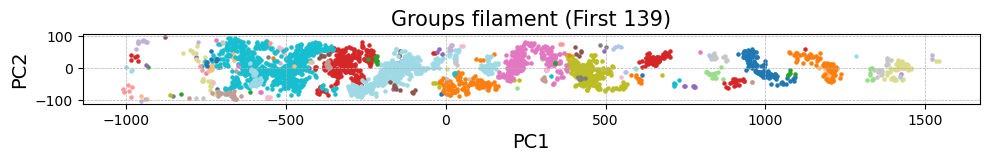

In [11]:
plot_groups_max_from_df(group_filament_coords, 'filament', max_groups = max_filament)

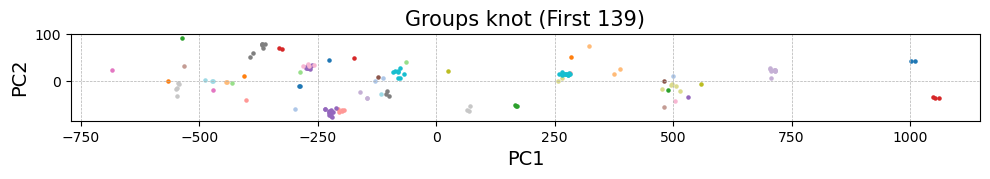

In [12]:
plot_groups_max_from_df(group_knot_coords, 'knot', max_groups = max_filament)

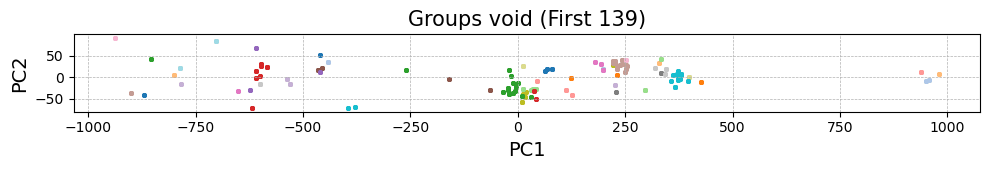

In [13]:
plot_groups_max_from_df(group_void_coords, 'void', max_groups = max_filament)